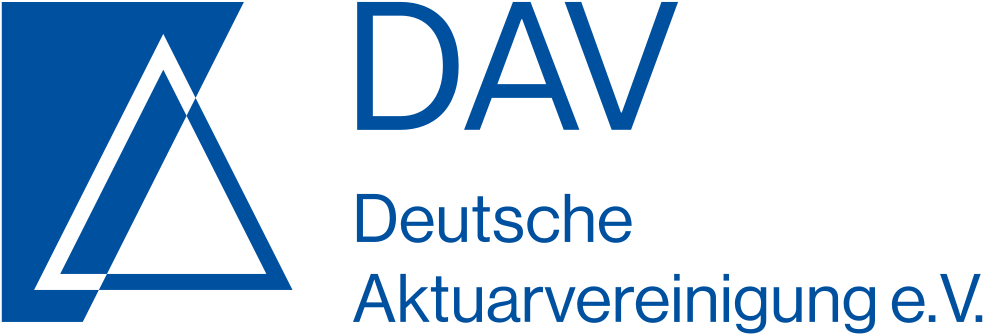

<p style="font-size:19px; text-align:left; margin-top:    25px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>A reimplementation of the Accumulated Local Effects (ALE) to enhance understanding the method<br></b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 25px">Florian Walla (<a href="mailto:Florian.Walla@hotmail.com">Florian.Walla@hotmail.com</a>)
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 25px">Dr. Benjamin Müller (<a href="mailto:benjamin1985.mueller@t-online.de">benjamin1985.mueller@t-online.de</a>)

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">1. Introduction</h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

Accumulated Local Effects (ALE) is a method for assessing marginal effects.

For an introductory guide to ALE, we recommend the "Interpretable Machine Learning" book by Christoph Molnar (https://christophm.github.io/interpretable-ml-book/ale.html).

For a more in-depth discussion of marginal effects, we suggest our notebook that compares ALE and Partial Dependence Plots (PDP) which will be published in this repository (https://github.com/DeutscheAktuarvereinigung/WorkingGroup_eXplainableAI_Notebooks/), too. Unlike the more widely known PDPs, ALE does not require the assumption of independent covariates. The purpose of this notebook is to deepen the understanding of the statistical aspects of ALE. However, it’s worth noting that the implementation presented here may not be the most efficient, mainly due to the use of a for-loop, which could be optimized. We employed the for-loop for didactic reasons.

Noteworthy implementations include the R package ALEPlot (https://cran.r-project.org/web/packages/ALEPlot/) developed by Dan Apley, the author of the original paper introducing ALE, and the Python package PyALE (https://pypi.org/project/PyALE/).

In the next section of the notebook, we implement a function that calculates ALE values. We then simulate data, train a machine learning model (Gradient Boosting Regressor) on it, and apply the ALE function to the model’s predictions. In the final part of the notebook, we compare our implementation with the implementation provided by the PyALE package.

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">2. Code</h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

In [2]:
# Load packages
import pandas as pd
import numpy as np
import math
import plotnine as p9
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

We follow these steps to calculate the ALE values:

1. Compute quantiles of the variable of interest (x variable) to determine the grid values for the subsequent calculations.
2. Identify the interval (intervals defined by grid values) in which each observation of the dataframe falls concerning the feature of interest.
3. Using a loop over all intervals, starting from the lowest:
    - Calculate the difference between two model predictions (concept: create two temporary datasets by replacing the variable of interest with the right and left boundaries for each observation in that interval, build predictions on these datasets,   and take the difference).
    - Average these differences over all observations in the interval.
4. Compute the cumulative sum of the averages across all intervals to obtain the "uncentered" ALE values.
5. Calculate the weighted average of all uncentered ALE values (using the number of observations per interval as the weight).
6. Subtract that average from the uncentered ALE values to derive the "centered" ALE values.

In [3]:
# Function which calculates ALE values

def calc_ale(model, df, x,  
             n_bins=10,
             use_predict_proba=False):
    """
    Function to calculate ALE values, see e.g.
    https://christophm.github.io/interpretable-ml-book/ale.html
    
    Parameters:
        model: an model object used for prediction, e.g. a sklearn object
        x: string column of df for which ALE has to be calculated. Column must
           be of numeric datatype. 
        df: pandas dataframe used for calculation of the ALE
        n_bins (as int): number of bins used for the calculation of ALE
        use_predict_proba: boolean should be True for binary classification 
                           problems and False for regression problems
                           if True, the "second probability
                           (predict_proba)[:,1]" is used
    """
    # calculate quantiles as grid for x values
    quantiles_x_grid = np.append(0, np.arange(1 / n_bins,
                                              1 + 1 / n_bins, 1 / n_bins))
    x_grid = df[x].quantile(quantiles_x_grid)
    # determine in which interval (intervals given by grid values)
    # each observation of the pandas dataframe lies in
    x_bin_no = pd.cut(df[x], bins = x_grid, labels=False,
                      include_lowest=True) # number of bin x lies in

    # Using a loop over all intervals, starting from the lowest:
    #    Calculate the difference between the model prediction at the right and
    #    left boundary, average that differences over all observations in the
    #    interval
    local_effects = np.ones(n_bins) # initialization

    for i in range(0, n_bins ): # loop over intervals
        
        df_obs_in_intervall = df[x_bin_no == i].copy()

        # set x-value to the left interval boundary
        df_left_interval_boundary = df_obs_in_intervall.copy()
        df_left_interval_boundary[x] = x_grid.iloc[i]

        # set x-value to the right interval boundary
        df_right_interval_boundary = df_obs_in_intervall.copy()
        df_right_interval_boundary[x] = x_grid.iloc[i+1]

        if use_predict_proba: # binary classification problem
            predictions_left_boundary = \
                            model.predict_proba(df_left_interval_boundary )[:,1]
            predictions_right_boundary = \
                           model.predict_proba(df_right_interval_boundary )[:,1]
        else: # regression problem
            predictions_left_boundary = model.predict(df_left_interval_boundary)
            predictions_right_boundary = model.predict(
                                                     df_right_interval_boundary)    

        local_effects[i] =  np.mean(predictions_right_boundary -
                                    predictions_left_boundary)

    # sum the averages of all intervals the get the "uncentered" ALE
    uncentered_acc_local_effects_temp = np.cumsum(local_effects)
    
    # add zero since the ALE for the 0% quantile is always zero
    uncentered_acc_local_effects = np.insert(uncentered_acc_local_effects_temp,
                                             0, 0)

    # Average all uncentered ALEs; Substract that average from the uncentered
    # ALEs to get "centered ALEs"   
    df_copy=df.copy()
    df_copy['x_bin_no'] = x_bin_no
    df_ale_average = df_copy.groupby(['x_bin_no']
                                    ).size().reset_index().rename(
                                                                columns={0:"n"})
    df_ale_average['uncentered_acc_local_effects'] = \
                                              uncentered_acc_local_effects_temp
    average_ale = np.average(df_ale_average['uncentered_acc_local_effects'],
                             weights=df_ale_average['n'])

    accumulated_local_effects = uncentered_acc_local_effects - average_ale
    
    return x_grid, accumulated_local_effects, uncentered_acc_local_effects

We simulate data with two explanatory variables using the following data-generating process:
 $y = x_1 + 2*x_2$
 where $x_1$ and $x_2$ follow a multivariate normal distribution with $\mu = [0, 0 ]$, unit variance
 and a correlation coefficient of $\rho = 0.5$.

In [4]:
# Simulate Data
rho = 0.5
N = 100_000

mean = [0, 0]
cov = [[1, rho], [rho, 1]]
list_x_vars = ["x_1", "x_2"]
list_y_var = ["y"]

# simulating data
x_1, x_2 = np.random.default_rng(seed=42).multivariate_normal(mean, cov, N).T

y = x_1 + 2*x_2
df = pd.DataFrame({"y": y, "x_1" :x_1, "x_2": x_2})

# train test split
last_row_train = math.floor(0.8*N)
df_train = df[:last_row_train].copy()
df_test = df[last_row_train:].copy()

df

,y,x_1,x_2
0,-1.311670,0.256099,-0.783885
1,-1.479447,-1.120192,-0.179627
2,4.417848,2.340736,1.038556
3,-0.490260,0.047408,-0.268834
4,-0.382871,0.441072,-0.411972
...,...,...,...
99995,2.263081,0.464448,0.899316
99996,-1.737032,-1.406698,-0.165167
99997,-5.621426,-1.822024,-1.899701
99998,-1.055991,-0.781670,-0.137161


Next, we apply a Gradient Boosting Regressor model, which shows a relatively good fit to the data. It’s important to emphasize that ALE is designed to illustrate the effect of a covariate within a model, rather than on the data itself. Therefore, its effectiveness depends on the model’s ability to accurately capture the relationship within the data.

In [5]:
# Estimate model
reg = GradientBoostingRegressor(random_state=0)
reg.fit(df_train[list_x_vars], np.ravel(df_train[list_y_var]))
df_test['prediction'] = reg.predict(df_test[list_x_vars])
print("MSE: " + str(mean_squared_error(df_test[list_y_var],
                                      df_test['prediction'])))
print("R2: " + str(r2_score(df_test[list_y_var], df_test['prediction'])))

MSE: 0.007436430182214981
R2: 0.9989200219035876


Now that we have both the data and the model, we can proceed to apply the calc_ale function mentioned earlier:

In [7]:
# apply the function
x_grid, accumulated_local_effects, uncentered_acc_local_effects = \
    calc_ale(model = reg, df = df_train[list_x_vars],x = 'x_1',
             n_bins=15, use_predict_proba=False)

Next, we plot the results:

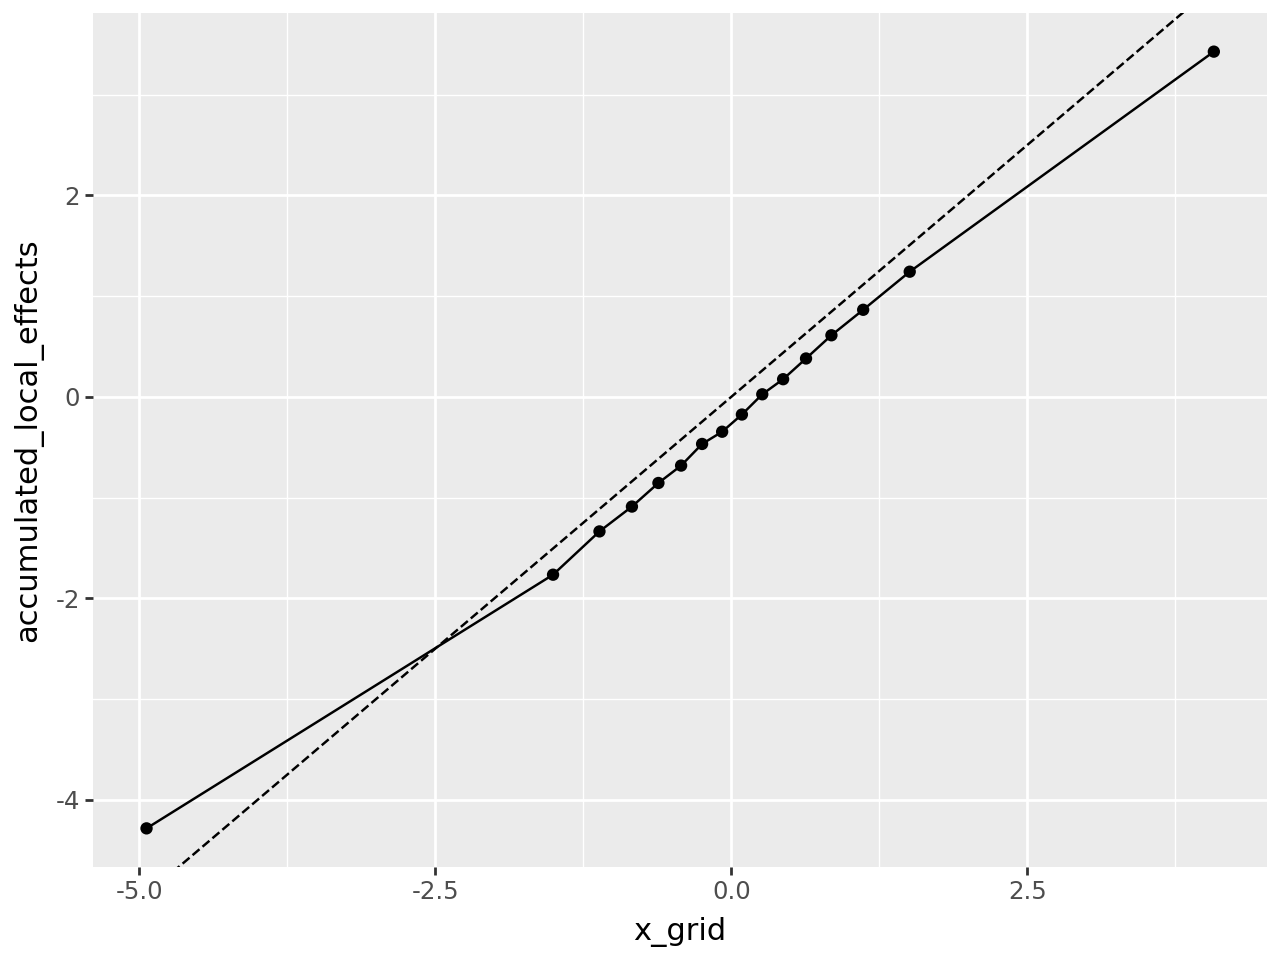

In [10]:
# Plot the function 
df_plot = pd.DataFrame({'x_grid': x_grid, 
                        'accumulated_local_effects':accumulated_local_effects})

( p9.ggplot(df_plot, p9.aes(x='x_grid', y='accumulated_local_effects'))
 + p9.geom_point()
 + p9.geom_line()
 + p9.geom_abline(intercept=0,
                  slope=1,
                  linetype="dashed"))

For the "x_1" variable, the ALE function produces the expected upward slope close to 1. 

Finally, we apply the function to "x_2" and observe  the expected upward slope of 2. 

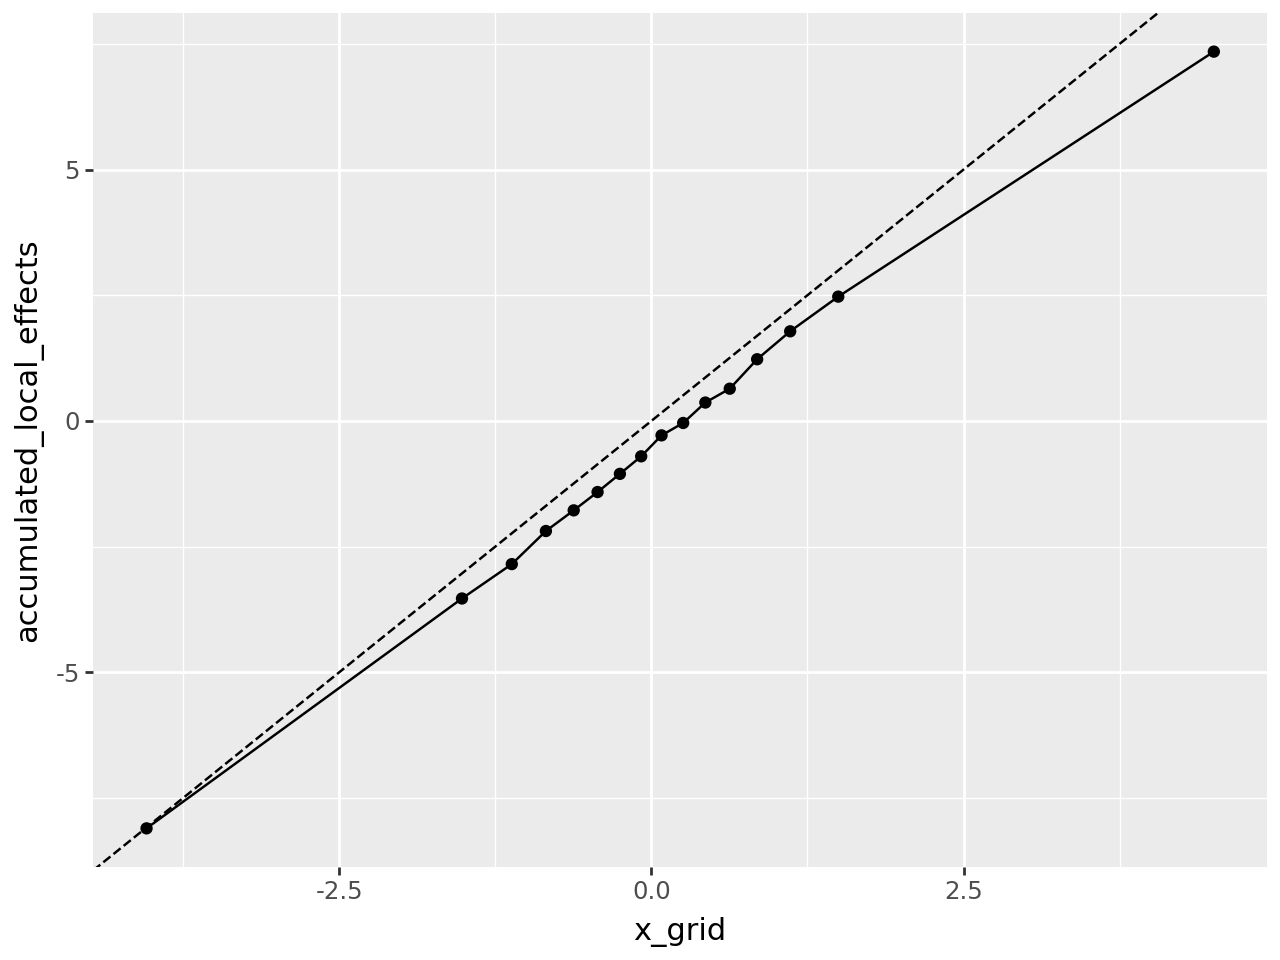

In [11]:
x_grid, accumulated_local_effects, uncentered_acc_local_effects = \
    calc_ale(model = reg, df = df_train[list_x_vars],x = 'x_2',
             n_bins=15, use_predict_proba=False)

# Plot the function 
df_plot = pd.DataFrame({'x_grid': x_grid, 
                        'accumulated_local_effects':accumulated_local_effects})

( p9.ggplot(df_plot, p9.aes(x='x_grid', y='accumulated_local_effects'))
 + p9.geom_point()
 + p9.geom_line()
 + p9.geom_abline(intercept=0,
                  slope=2,
                  linetype="dashed"))

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">3. Differences to the implementation in the PyALE module</h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

In this chapter, we compare our implementation of the calc_ALE function to the implementation in the PyALE module (https://github.com/DanaJomar/PyALE).
The results are very similar. However, we calculate the "mean ALE effect," which is used to center the ALE values to a mean effect of zero, in a different way. This difference explains the variation between the two implementations.

To facilitate a comparison, we copied the necessary functions from GitHub and made some slight modifications—adding comments and returning intermediate results.

The PyALE module uses a specific method to calculate quantiles to replicate R's quantile calculation. Since we want to compare the exact same grid for the ALE function, we modified our calc_ale function to accept a custom grid as input:

In [12]:
def modified_calc_ale(model, df, x,  
             n_bins=None,
             bins=None,
             use_predict_proba=False):
    """
    Function to calculate ALE values,
    see e.g. https://christophm.github.io/interpretable-ml-book/ale.html
    
    Parameters:
        model: an model object used for prediction, e.g. a sklearn object
        x: string column of df for which ALE has to be calculated.
           Column must be of numeric datatype. 
        df: pandas dataframe used for calculation of the ALE
        n_bins (as int): number of bins used for the calculation of ALE
        bins: np.array with bin values - to faciliate comparison with PyALE
        use_predict_proba: boolean should be True for binary classification
                           problems and False for Regression problems
                           if True, the "second probability
                           (predict_proba)[:,1]" is used
    """

    # --------------------------------------------------------------------------
    # FROM HERE
    
    if (bins is None) and (n_bins is None):
        raise ValueError("Please either provide bins or n_bins")
    if (bins is not None) and (n_bins is not None):
        raise ValueError("Please either provide bins or n_bins, not both")
   
    if bins is None:  # calculate quantiles as grid for x values
        quantiles_x_grid = np.append(0, np.arange(1 / n_bins, 1 + 1 / n_bins,
                                                  1 / n_bins))
        x_grid = df[x].quantile(quantiles_x_grid)
    else: # bins given
        
        # define x_grid as pandas Series as above
        n_bins = len(bins) - 1
        quantiles_x_grid = np.append(0, np.arange(1 / n_bins, 1 + 1 / n_bins,
                                                  1 / n_bins))
        x_grid = pd.Series(data = bins, index= quantiles_x_grid)

    # TO HERE are the modifications in comparison to calc_ale
    # --------------------------------------------------------------------------

    # determine in which interval (intervals given by grid values) each
    # observation of the pandas dataframe lies in
    x_bin_no = pd.cut(df[x], bins = x_grid, labels=False,
                      include_lowest=True) # number of bin x lies in

    # Using a loop over all intervals, starting from the lowest:
    #    Calculate the difference between the model prediction at the right
    #    and left boundary, average that differences over all observations
    #    in the interval
    local_effects = np.ones(n_bins) # initialization

    for i in range(0, n_bins ): # loop over intervals
        
        df_obs_in_intervall = df[x_bin_no == i].copy()

        # set x-value to the left interval boundary
        df_left_interval_boundary = df_obs_in_intervall.copy()
        df_left_interval_boundary[x] = x_grid.iloc[i]

        # set x-value to the right interval boundary
        df_right_interval_boundary = df_obs_in_intervall.copy()
        df_right_interval_boundary[x] = x_grid.iloc[i+1]

        if use_predict_proba: # binary classification problem
            predictions_left_boundary = \
                             model.predict_proba(df_left_interval_boundary)[:,1]
            predictions_right_boundary = \
                           model.predict_proba(df_right_interval_boundary )[:,1]
        else: # regression problem
            predictions_left_boundary = model.predict(df_left_interval_boundary)
            predictions_right_boundary = model.predict(
                                                     df_right_interval_boundary)    

        local_effects[i] =  np.mean(predictions_right_boundary -
                                    predictions_left_boundary)

    # sum the averages of all intervals the get the "uncentered" ALE
    uncentered_acc_local_effects_temp = np.cumsum(local_effects)

    # add zero since the ALE for the 0% quantile is always zero
    uncentered_acc_local_effects = np.insert(uncentered_acc_local_effects_temp,
                                             0, 0)

    # Average all uncentered ALEs; Substract that average from the uncentered
    # ALEs to get "centered ALEs"   
    df_copy=df.copy()
    df_copy['x_bin_no'] = x_bin_no
    df_ale_average = df_copy.groupby(['x_bin_no']
                                ).size().reset_index().rename(
                                                            columns={0:"n"})
    df_ale_average['uncentered_acc_local_effects'] = \
                                               uncentered_acc_local_effects_temp
    average_ale = np.average(df_ale_average['uncentered_acc_local_effects'],
                             weights=df_ale_average['n'])

    accumulated_local_effects = uncentered_acc_local_effects - average_ale
    
    return x_grid, accumulated_local_effects, uncentered_acc_local_effects_temp

We continue with some slight modifications of the function *aleplot_1D_continuous*
of the package PyALE.

In [13]:
from PyALE._src.lib import quantile_ied

def modified_aleplot_1D_continuous(X, model, feature, grid_size=20,
                                   include_CI=True, C=0.95):
    """Compute the accumulated local effect of a numeric continuous feature.

    This function divides the feature in question into grid_size intervals
    (bins) and computes the difference in prediction between the first and last
    value of each interval and then centers the results.

    Arguments:
    X -- A pandas DataFrame to pass to the model for prediction.
    model -- Any python model with a predict method that accepts X as input.
    feature -- String, the name of the column holding the feature being studied.
    grid_size -- An integer indicating the number of intervals into which the
                 feature range is divided.
    include_CI -- A boolean, if True the confidence interval
    of the effect is returned with the results.
    C -- A float the confidence level for which to compute the confidence
         interval

    Return: A pandas DataFrame containing for each bin: the size of the sample
    in it and the accumulated centered effect of this bin.
    """
    ## Comments starting with ## are from the authors of this notebook

    quantiles = np.linspace(0, 1, grid_size + 1, endpoint=True)
    # use customized quantile function to get the same result as
    # type 1 R quantile (Inverse of empirical distribution function)
    bins = [X[feature].min()] + quantile_ied(X[feature], quantiles).to_list()
    bins = np.unique(bins)

    ## interval in which the observation lies in
    feat_cut = pd.cut(X[feature], bins, include_lowest=True)

    ## No of interval in which the observation lies in
    bin_codes = feat_cut.cat.codes
    bin_codes_unique = np.unique(bin_codes) 

    X1 = X.copy()
    X2 = X.copy()
    X1[feature] = [bins[i] for i in bin_codes] ## get the left interval border
    
    ## get the right interval border
    X2[feature] = [bins[i + 1] for i in bin_codes]
    
    try:
        y_1 = model.predict(X1).ravel()
        y_2 = model.predict(X2).ravel()
    except Exception as ex:
        raise Exception(
            "Please check that your model is fitted, and accepts X as input."
        )

    ## df containing the right interval boundary and the difference in
    ## prediction between the left and right boundary
    delta_df = pd.DataFrame({feature: bins[bin_codes + 1], "Delta": y_2 - y_1})
    res_df = delta_df.groupby([feature], observed=False).Delta.agg(
        [("eff", "mean"), "size"]
    )  ## yields the same results as accumulated local effects in our function
    
    ## inserted to show differences between the two functions:
    res_df_local_effects = res_df.copy()
    
    res_df["eff"] = res_df["eff"].cumsum()
    res_df_accumulated_local_effects = res_df.copy()
    res_df.loc[min(bins), :] = 0
    # subtract the total average of a moving average of size 2
    mean_mv_avg = (
        (res_df["eff"] + res_df["eff"].shift(1, fill_value=0)) /
         2 * res_df["size"]
    ).sum() / res_df["size"].sum()
    res_df = res_df.sort_index().assign(eff=res_df["eff"] - mean_mv_avg)
    if include_CI:
        ci_est = delta_df.groupby(feature, observed=False).Delta.agg(
            [("CI_estimate", lambda x: CI_estimate(x, C=C))]
        )
        ci_est = ci_est.sort_index()
        lowerCI_name = "lowerCI_" + str(int(C * 100)) + "%"
        upperCI_name = "upperCI_" + str(int(C * 100)) + "%"
        res_df[lowerCI_name] = res_df[["eff"]].subtract(ci_est["CI_estimate"],
                                                        axis=0)
        res_df[upperCI_name] = upperCI = res_df[["eff"]].add(
            ci_est["CI_estimate"], axis=0
        )
    return res_df, bins, res_df_local_effects, res_df_accumulated_local_effects

Now, we run both functions on the same grid:

In [15]:
# modified function of PyALE
pyALE_res_df, pyALE_bins, pyALE_res_df_local_effects,\
pyALE_res_df_accumulated_local_effects = \
                        modified_aleplot_1D_continuous(X=df_train[list_x_vars],
                                                       model=reg,
                                                       feature='x_1',
                                                       grid_size=5,
                                                       include_CI= False)

In [16]:
# (modified) own function
x_grid, accumulated_local_effects,\
uncentered_acc_local_effects_temp = modified_calc_ale(model=reg,
                                                      df=df_train[list_x_vars],
                                                      x='x_1',
                                                      bins=pyALE_bins,
                                                      use_predict_proba=False)

When comparing the uncentered Accumulated Local Effects (column eff) in the dataframe of the PyALE function, we observe the same results:

In [17]:
# values of PyALE package
pyALE_res_df_accumulated_local_effects

,eff,size
x_1,,
-0.839667,3.199187,16000
-0.246984,3.826312,16000
0.261210,4.323936,16000
0.845294,4.905090,16000
4.075342,7.721914,16000


In [18]:
# values of self-implemented function
uncentered_acc_local_effects_temp

array([3.19918708, 3.82631197, 4.32393582, 4.90508995, 7.72191382])

In [25]:
print('Comparison of uncentered local effects:',
      np.array_equal(pyALE_res_df_accumulated_local_effects['eff'].values,
                     uncentered_acc_local_effects_temp))

Comparison of uncentered local effects: False


In both implementations, a zero is added as the ALE value for the left edge of the grid, as there is no accumulated effect at the minimum possible value.

To center the ALE values (by subtracting the mean effect), the implementations differ slightly:
We calculate the weighted average of all uncentered ALE values, where the weights are the number of observations falling into each grid.
In contrast, PyALE first averages the effects within each bin and then computes the weighted average.
This difference results in ALE effects that differ by a consistent amount, due to the subtraction of a different "mean ALE effect."

In [21]:
pyALE_res_df

,eff,size
x_1,,
-4.939506,-4.023096,0.0
-0.839667,-0.823909,16000.0
-0.246984,-0.196784,16000.0
0.261210,0.300839,16000.0
0.845294,0.881994,16000.0
4.075342,3.698817,16000.0


In [22]:
accumulated_local_effects

array([-4.79528773, -1.59610065, -0.96897576, -0.47135191,  0.10980222,
        2.92662609])

In [23]:
print('Comparison of centered local effects:',
      pyALE_res_df['eff'].values - accumulated_local_effects)

Comparison of centered local effects: [0.77219138 0.77219138 0.77219138 0.77219138 0.77219138 0.77219138]


We believe that both implementations are valid solutions and note that often the primary interest lies in the shape of the ALE functions rather than in the y-intercept.

Additionally, the difference decreases as the number of bins increases:

In [24]:
# modified function of PyALE
pyALE_res_df, pyALE_bins, pyALE_res_df_local_effects,\
pyALE_res_df_accumulated_local_effects =\
                        modified_aleplot_1D_continuous(X= df_train[list_x_vars],
                                                       model=reg,
                                                       feature='x_1',
                                                       grid_size=1000,
                                                       include_CI= False)
# (modified) own function
x_grid, accumulated_local_effects,\
uncentered_acc_local_effects_temp = modified_calc_ale(model=reg,
                                                      df=df_train[list_x_vars],
                                                      x = 'x_1',
                                                      bins = pyALE_bins,
                                                      use_predict_proba=False)

print('Comparison of centered local effects:',
      pyALE_res_df['eff'].values - accumulated_local_effects)

Comparison of centered local effects: [0.00391334 0.00391334 0.00391334 ... 0.00391334 0.00391334 0.00391334]


<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">4. Further Reading</h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

We published a closely related notebook that examines the behavior of ALE and PDP values within the same repository. Additionally, the DAV repository contains excellent notebooks that introduce various explainable methods (https://github.com/DeutscheAktuarvereinigung/WorkingGroup_eXplainableAI_Notebooks/).

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">5. Remarks on actuarial due diligence</h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

As an actuary and data scientist, it is crucial to understand the methods one applies to gain insights from data. Given today’s widespread distribution of open-source software packages, it is tempting to use a method and trust that it has been validated by the community. However, many decisions are made during the implementation of an algorithm, and these decisions are often undocumented and only visible in the code itself. Therefore, reimplementing a method and 'revisiting' these decisions can significantly enhance the understanding of the method and its implementation.
However, this can be a substantial time investment. In practice, the actuary faces a trade-off between producing results and deeply understanding the methods used. A good compromise might be to focus on specific aspects of an implementation.

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">6. Limitations of our implementation </h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

Our implementation assumes numerical data for the x-grid. If you want to calculate an ALE for ordinal data with low to medium cardinality, we suggest using each unique value of the original variable as a grid point.

<h1 style="font-size:18px; font-weight:bold; margin-top: 15px;">7. Conclusion </h1>
<hr style="background-color: black; height: 3px; border: 0; margin-bottom: 15px;"> </hr>

We were able to reproduce the results of the PyALE and explain the differences between the two implementations. The discrepancy we found is a good example of a decision that must be made when implementing an algorithm, where multiple solutions might be possible. We hope that this notebook has improved the reader’s understanding of ALE values. 

Please note that we utilized ChatGPT to enhance the English language in this paper.